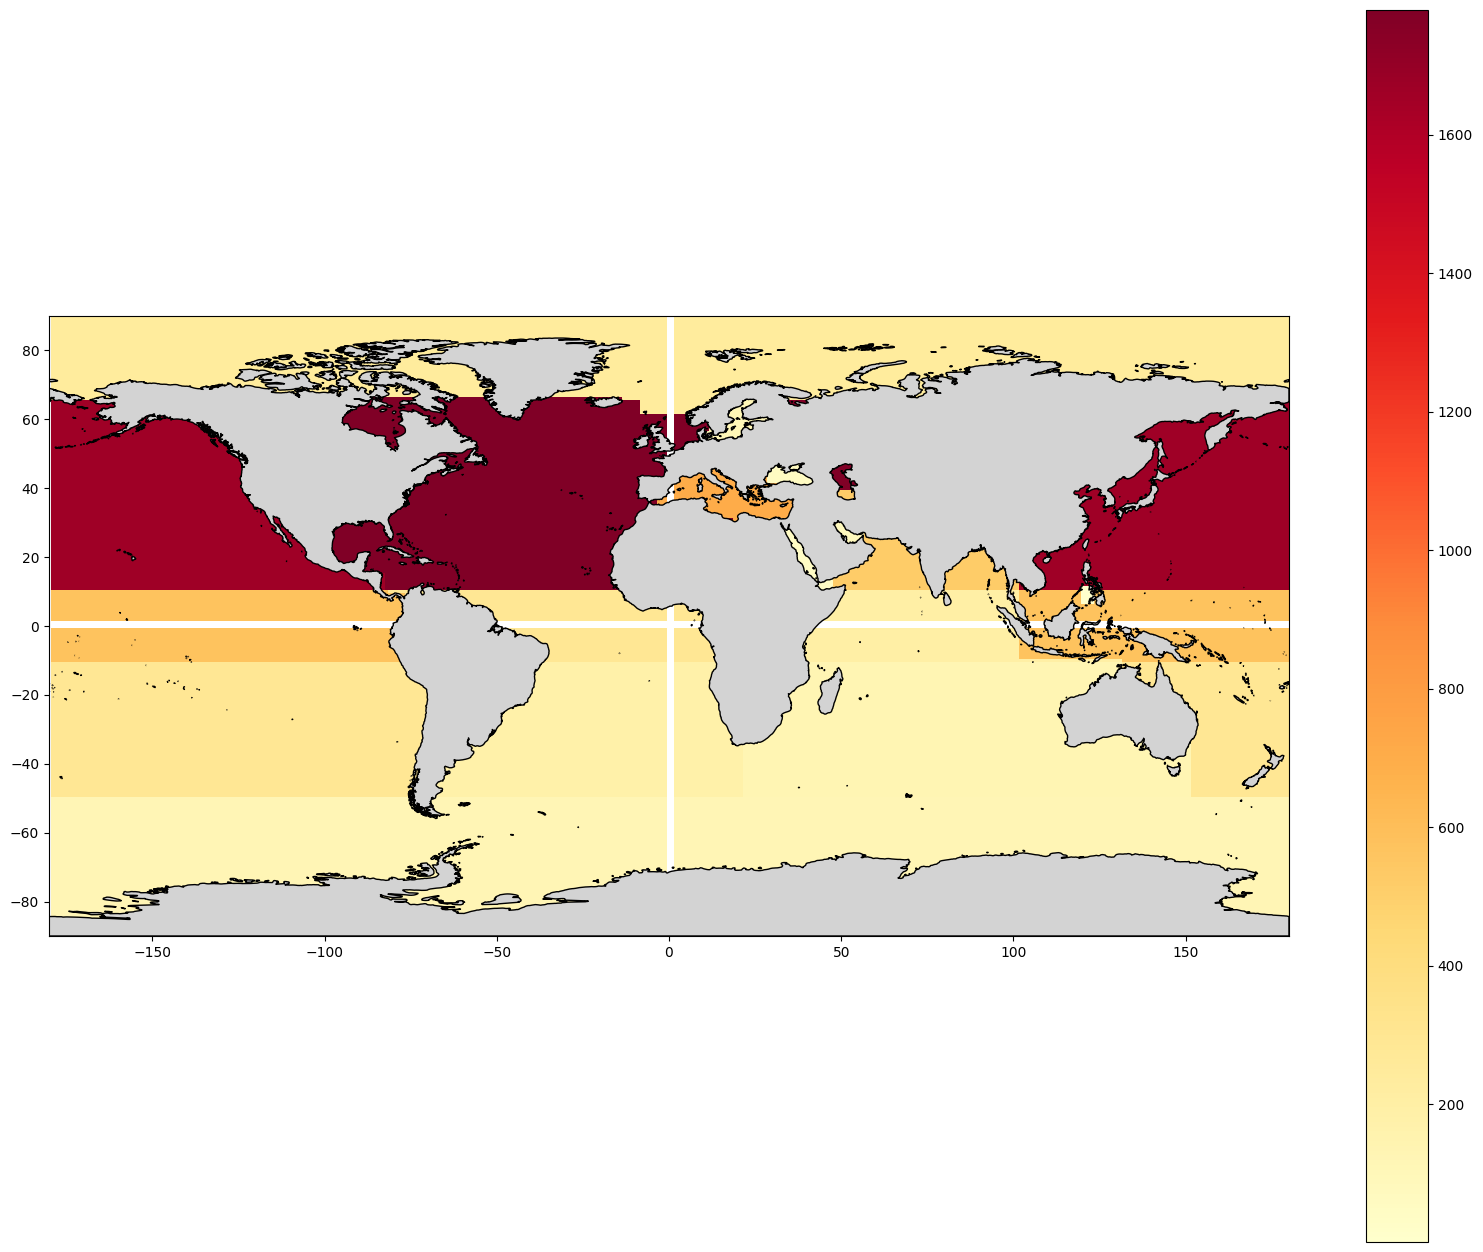

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt

range_area = pd.read_csv(r'D:\Documentos\Projects\mpl_topics\mpl_topics_2025\NER\maps\range_area_counts.csv')

ocean_polygons = []

for index, row in range_area.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    basin = row['basin']
    basin_count = row['basin_count']
    
    # Create the polygon using the latitude and longitude values
    polygon = Polygon([(longitude, latitude),
                       (longitude + 1, latitude),
                       (longitude + 1, latitude + 1),
                       (longitude, latitude + 1)])
    
    # Add the ocean polygon to the list
    ocean_polygons.append((basin_count, basin, polygon))


columns = ['basin_count', 'basin', 'geometry']
ocean_df = gpd.GeoDataFrame(ocean_polygons, columns=columns, geometry='geometry')

# Read the world continents shapefile from Natural Earth
continents = gpd.read_file(r'D:\Documentos\Projects\mpl_topics\mpl_topics_2025\NER\maps\world map\ne_50m_land.shp')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 16))

# Plot the continents
continents.plot(ax=ax, color='lightgray', edgecolor='black', zorder=2)

# Plot the oceans
ocean_df.plot(ax=ax, column='basin_count', categorical=False, legend=True,
              cmap='YlOrRd', linewidth=0.8, edgecolor='none', zorder=1)


# Set the title
ax.set_title("")
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)

# Show the plot
plt.show()

In [2]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Create instances with longitude values of 0.5 and -0.5 for all latitudes
longitude_instances = pd.DataFrame({'Latitude': range(-90, 91),
                                    'Longitude': [0.5] * 181})

negative_longitude_instances = pd.DataFrame({'Latitude': range(-90, 91),
                                             'Longitude': [-0.5] * 181})

# Concatenate the longitude instances
all_longitude_instances = pd.concat([longitude_instances, negative_longitude_instances])

# Create instances with latitude values of 0.5 and -0.5 for all longitudes
latitude_instances = pd.DataFrame({'Latitude': [0.5] * 361,
                                   'Longitude': range(-180, 181)})

negative_latitude_instances = pd.DataFrame({'Latitude': [-0.5] * 361,
                                            'Longitude': range(-180, 181)})

# Concatenate the latitude instances
all_latitude_instances = pd.concat([latitude_instances, negative_latitude_instances])
all_new_points = pd.concat([all_latitude_instances, all_longitude_instances])

# Assuming your DataFrame is called df
grid_points = []
for index, row in all_new_points.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    point = Point(longitude, latitude)
    grid_points.append(point)

# Convert the grid points to a GeoDataFrame
grid_points_df = gpd.GeoDataFrame(geometry=grid_points)

# Create a copy of the range_area dataframe
range_area_filled = range_area.copy()

# Find the closest existing point for each grid point
existing_points = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in
                                             zip(range_area['Longitude'], range_area['Latitude'])])

# Convert points to a 2D array
existing_points_array = np.array([[p.x, p.y] for p in existing_points.geometry])

# Create a NearestNeighbors model and fit the existing points
knn = NearestNeighbors(n_neighbors=5)
knn.fit(existing_points_array)

# Convert grid points to a 2D array
grid_points_array = np.array([[p.x, p.y] for p in grid_points_df.geometry])

# Find the nearest existing point for each grid point
distances, indices = knn.kneighbors(grid_points_array)

# Assign the basin and basin_count values from the closest existing point (first nearest neighbor)
grid_points_df['basin'] = range_area.loc[indices[:, 0].flatten(), 'basin'].values
grid_points_df['basin_count'] = range_area.loc[indices[:, 0].flatten(), 'basin_count'].values

# Append the grid points to the filled range_area dataframe
grid_points_df['Latitude'] = grid_points_df.geometry.y
grid_points_df['Longitude'] = grid_points_df.geometry.x
range_area_filled = pd.concat([range_area_filled, grid_points_df[['Latitude', 'Longitude', 'basin', 'basin_count']]], ignore_index=True)


In [3]:
ocean_polygons = []

for index, row in range_area_filled.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    basin = row['basin']
    basin_count = row['basin_count']
    
    try:
        # Create the polygon using the latitude and longitude values
        polygon = Polygon([(longitude, latitude),
                           (longitude, latitude + 1),
                           (longitude + 1, latitude + 1),
                           (longitude + 1, latitude),
                           (longitude, latitude)])  # Ensure the ring is closed
        
        # Add the ocean polygon to the list
        ocean_polygons.append((basin_count, basin, polygon))
    except Exception as e:
        print(f"Error creating polygon for index {index}: {e}")

columns = ['basin_count', 'basin', 'geometry']
ocean_df = gpd.GeoDataFrame(ocean_polygons, columns=columns, geometry='geometry')

# Remove Climatology Range from basins
ocean_df = ocean_df[ocean_df['basin'] != 'Climatology Range']


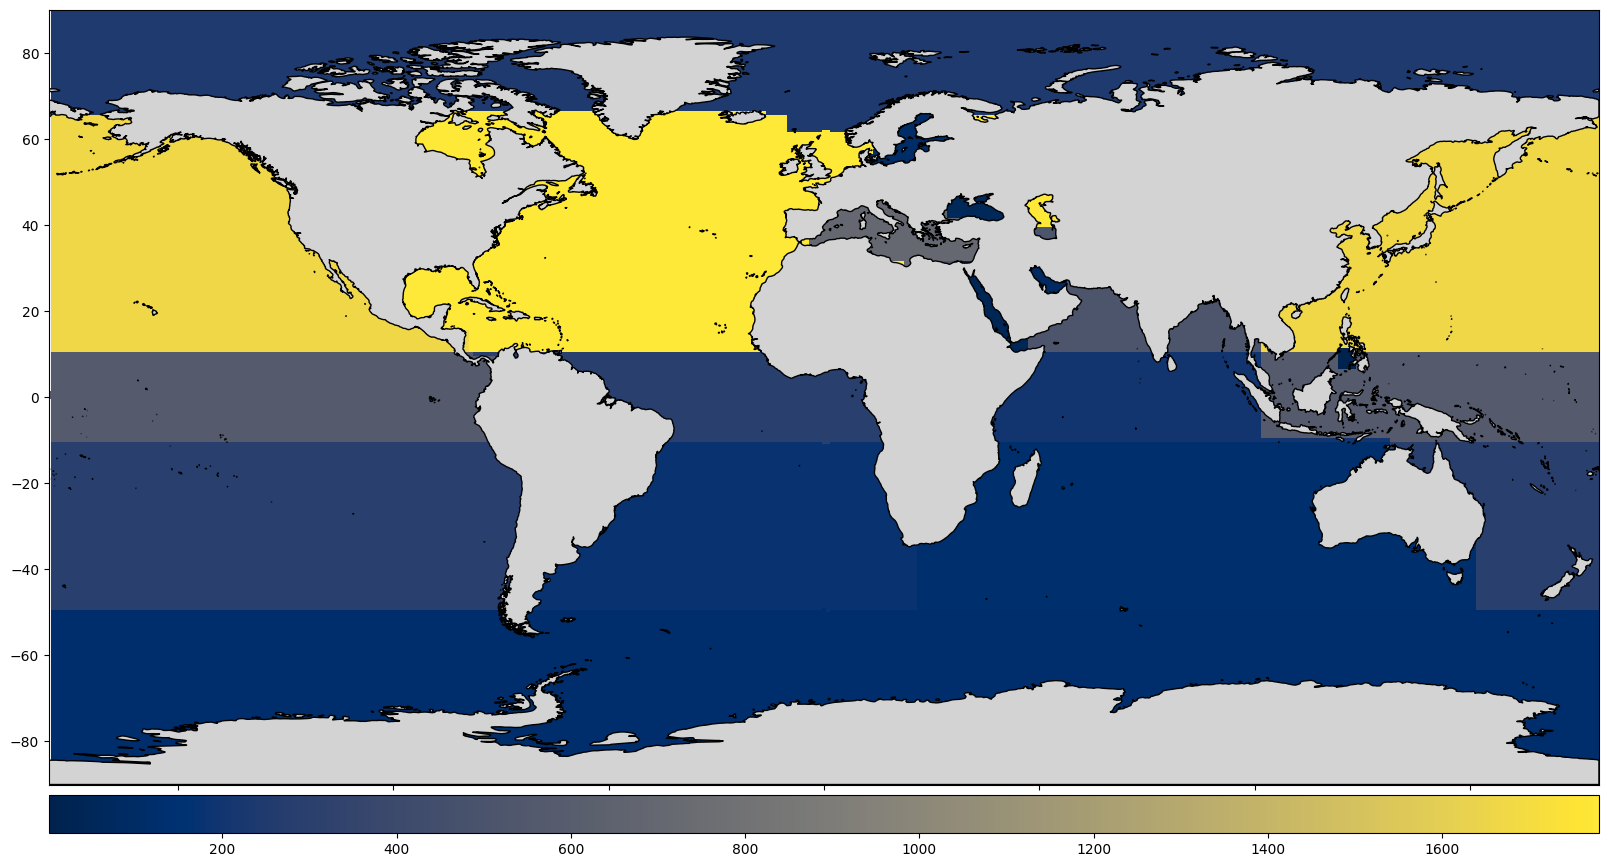

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 16))

# Plot the continents
continents.plot(ax=ax, color='lightgray', edgecolor='black', zorder=2)
cmap = cm.cividis

# Plot the oceans
ocean_df.plot(ax=ax, column='basin_count', categorical=False, legend=False,
              cmap=cmap, linewidth=0.8, edgecolor='none', zorder=1)

# Create the colorbar
sm = cm.ScalarMappable(cmap=cmap)
sm.set_array(ocean_df['basin_count'])
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.1)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

# Set the title
ax.set_title("")
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)

# Show the plot
plt.show()

In [14]:
unique_basins

,basin_count,basin,geometry
0,122,Antarctic,"POLYGON ((1.5 -89.5, 1.5 -88.5, 2.5 -88.5, 2.5..."
14320,181,South Atlantic,"POLYGON ((1.5 -49.5, 1.5 -48.5, 2.5 -48.5, 2.5..."
14340,127,South Indian,"POLYGON ((21.5 -49.5, 21.5 -48.5, 22.5 -48.5, ..."
14388,127,Coastal S Indian,"POLYGON ((69.5 -49.5, 69.5 -48.5, 70.5 -48.5, ..."
14470,287,South Pacific,"POLYGON ((151.5 -49.5, 151.5 -48.5, 152.5 -48...."
14603,287,Coastal S Pac,"POLYGON ((-75.5 -49.5, -75.5 -48.5, -74.5 -48...."
14610,181,Coastal S Atlantic,"POLYGON ((-68.5 -49.5, -68.5 -48.5, -67.5 -48...."
28282,289,Equatorial Atlant,"POLYGON ((1.5 -10.5, 1.5 -9.5, 2.5 -9.5, 2.5 -..."
28294,289,Coastal Eq Atlant,"POLYGON ((13.5 -10.5, 13.5 -9.5, 14.5 -9.5, 14..."
28302,196,Coastal Eq Indian,"POLYGON ((21.5 -10.5, 21.5 -9.5, 22.5 -9.5, 22..."


In [15]:
unique_basins = ocean_df.drop_duplicates(subset='basin')
for index, row in unique_basins.iterrows():
    basin = row['basin']
    count = row['basin_count']
    print(basin, count)

Antarctic 122
South Atlantic 181
South Indian 127
Coastal S Indian 127
South Pacific 287
Coastal S Pac 287
Coastal S Atlantic 181
Equatorial Atlant 289
Coastal Eq Atlant 289
Coastal Eq Indian 196
Equatorial Indian 196
Coastal Eq Pac 574
Equatorial Pac 574
Sulu Sea 1
Coastal N Atlantic 1780
Coastal N Indian 519
Red Sea 40
North Indian 519
Coastal N Pac 1664
North Pacific 1664
North Atlantic 1780
Persian Gulf 80
Mediteranean 706
Black Sea 51
Baltic Sea 107
Arctic 242


In [17]:
unique_basins = unique_basins.drop_duplicates(subset='basin_count')
total_basin_count = unique_basins['basin_count'].sum()
print("Total basin count:", total_basin_count)


Total basin count: 6966


C:\Users\Henrique\AppData\Local\Temp\ipykernel_17304\477361191.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('cividis', len(bins))


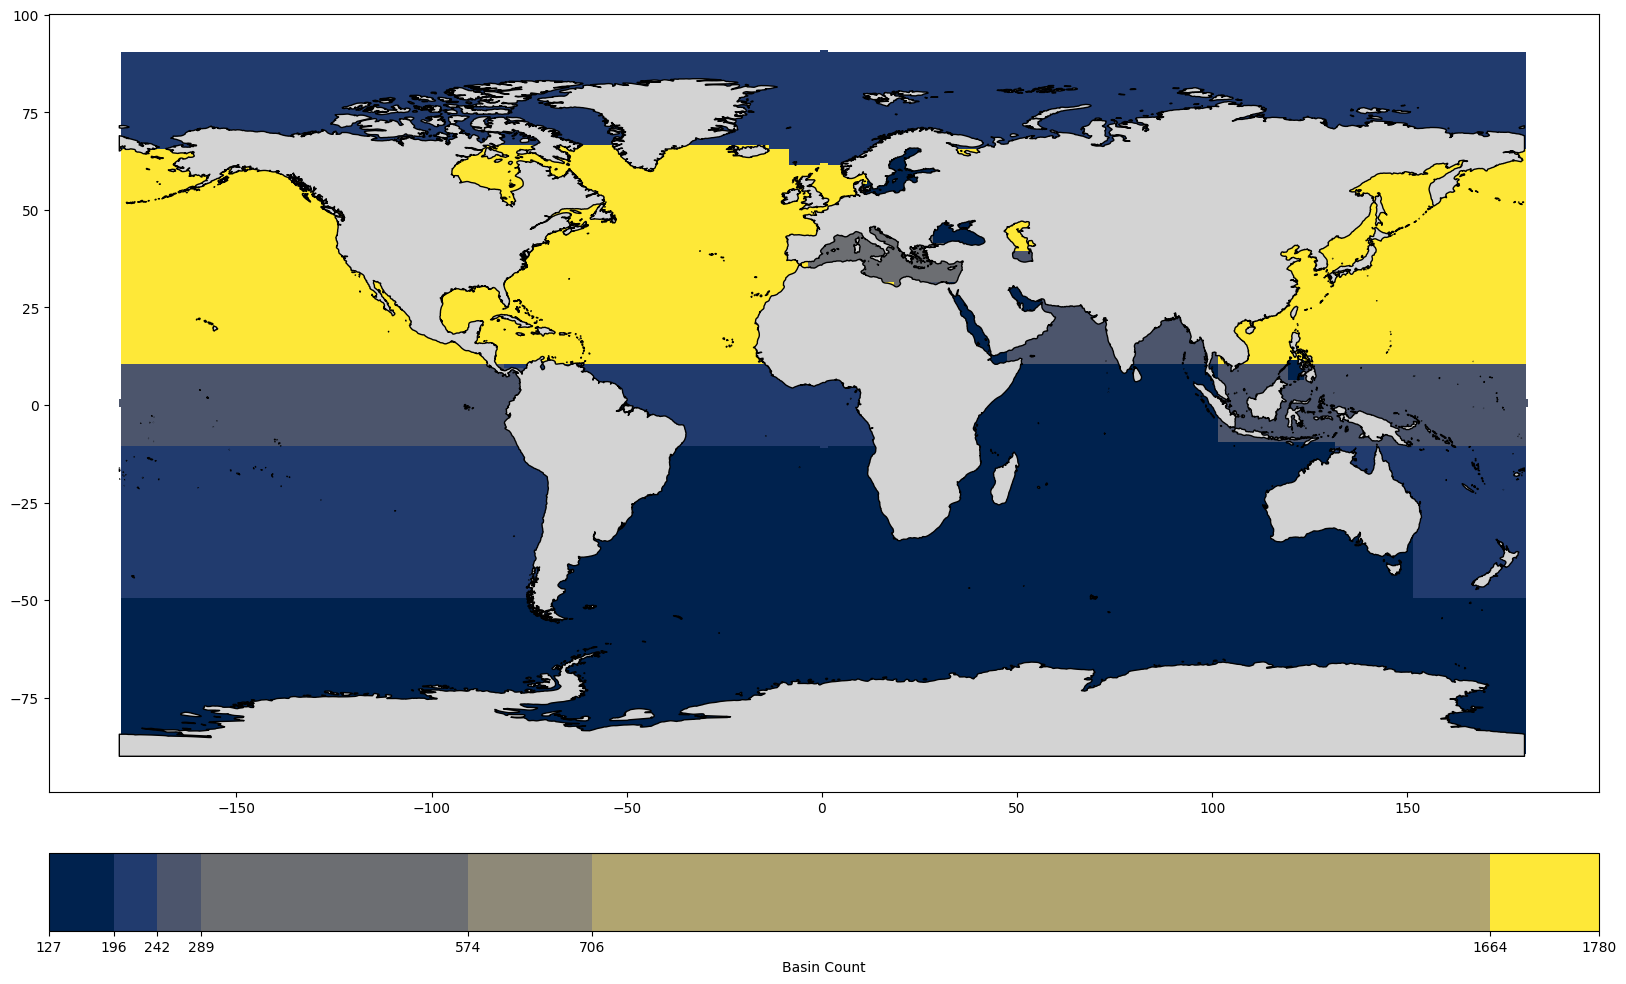

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import mapclassify

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 16))

# Plot the continents
continents.plot(ax=ax, color='lightgray', edgecolor='black', zorder=2)

# Get the unique basin_count values
unique_values = ocean_df['basin_count'].unique()

# Define the number of desired bins
k = 8

# Compute the natural breaks bin edges
bins = mapclassify.NaturalBreaks(ocean_df['basin_count'], k=k).bins

# Create the discrete colormap
cmap = cm.get_cmap('cividis', len(bins))

# Plot the oceans
ocean_df.plot(ax=ax, column='basin_count', categorical=False, legend=False,
              cmap=cmap, linewidth=0.8, edgecolor='none', zorder=1)

# Set the title
ax.set_title("")

# Create the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=colors.BoundaryNorm(bins, cmap.N))
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', ticks=bins, pad=0.05, spacing='proportional')
cbar.set_label('Basin Count')

# Show the plot
plt.show()


(-90.0, 90.0)

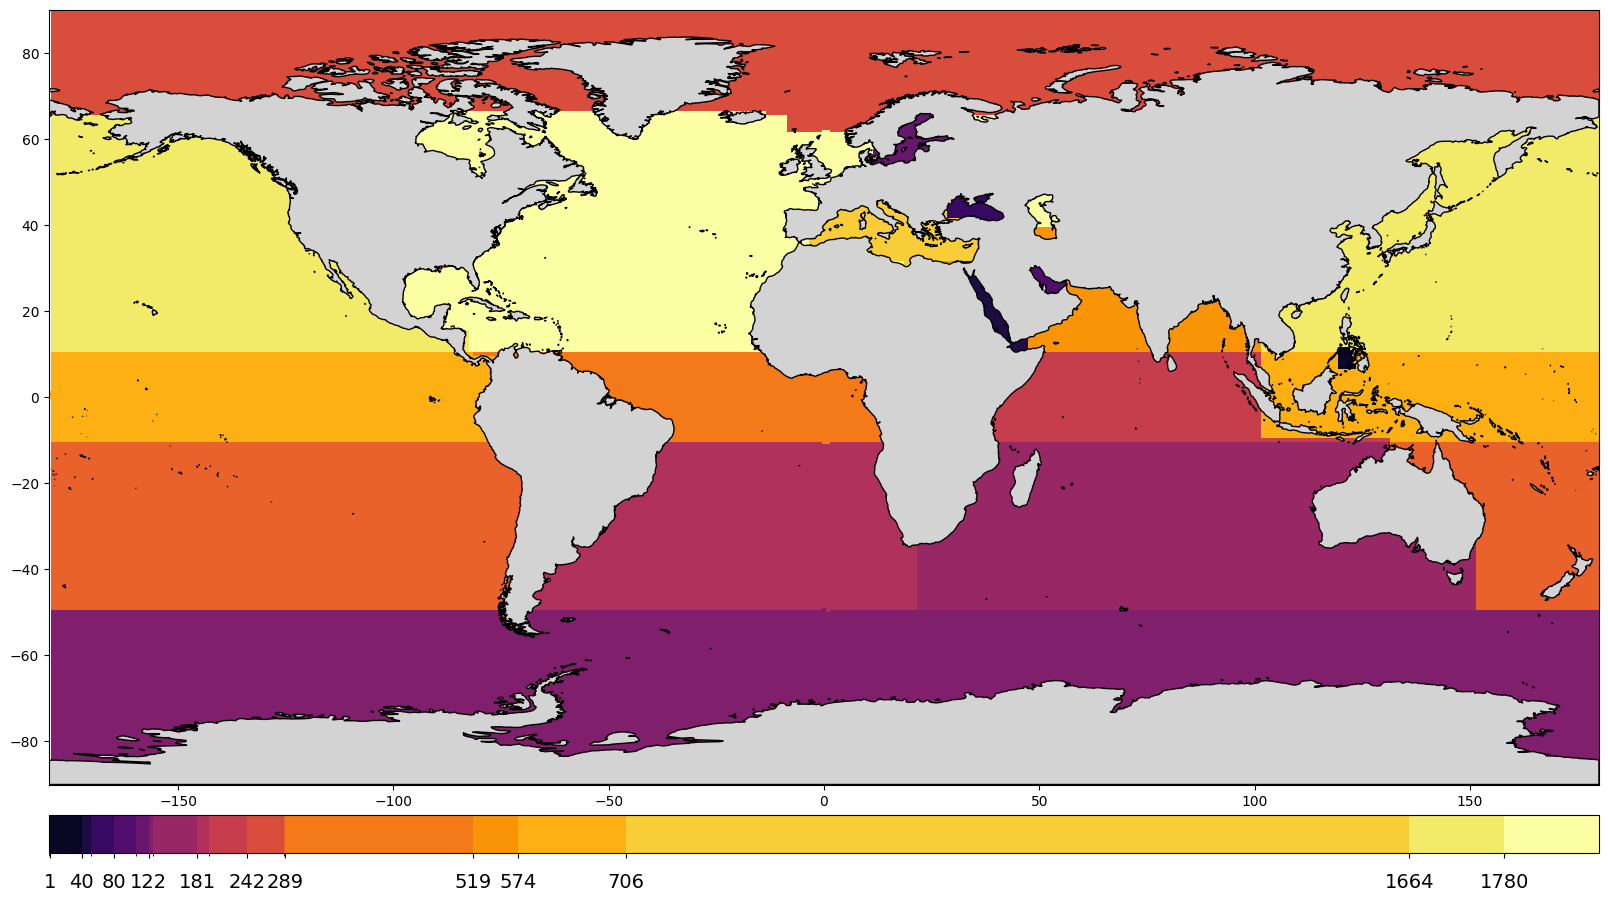

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# Assuming ocean_df and continents DataFrame are already loaded

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the continents
continents.plot(ax=ax, color='lightgray', edgecolor='black', zorder=2)

# Create the discrete colormap
cmap = cm.inferno
unique_values = np.unique(ocean_df['basin_count'])
bounds = np.concatenate(([0], unique_values))
norm = colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Plot the oceans
ocean_df.plot(ax=ax, column='basin_count', categorical=False, legend=False,
              cmap=cmap, norm=norm, linewidth=0.8, edgecolor='none', zorder=1)

# Create the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.3)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cax, orientation='horizontal', spacing='proportional', extendrect=True, extendfrac='auto')

# Set the ticks and tick labels
ticks = [1, 40, 80, 122, 181, 242, 289, 519, 574, 706, 1664, 1780]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks, fontsize=14)

# Adjust the tick labels spacing and alignment
cbar.ax.xaxis.set_tick_params(pad=10)

# Set the title
ax.set_title("")
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)




In [6]:
# Save as SVG
fig.savefig(r'D:\Documentos\Projects\mpl_topics\mpl_topics_2025\graphs\map.svg', format='svg', bbox_inches='tight')

# Save as PNG with high resolution
fig.savefig(r'D:\Documentos\Projects\mpl_topics\mpl_topics_2025\graphs\map.png', format='png', dpi=300, bbox_inches='tight')


In [8]:
unique_values

array([   1,   40,   51,   80,  107,  122,  127,  181,  196,  242,  287,
        289,  519,  574,  706, 1664, 1780], dtype=int64)

In [23]:
unique_basins = np.unique(ocean_df['basin'])
unique_basins

array(['Antarctic', 'Arctic', 'Baltic Sea', 'Black Sea',
       'Coastal Eq Atlant', 'Coastal Eq Indian', 'Coastal Eq Pac',
       'Coastal N Atlantic', 'Coastal N Indian', 'Coastal N Pac',
       'Coastal S Atlantic', 'Coastal S Indian', 'Coastal S Pac',
       'Equatorial Atlant', 'Equatorial Indian', 'Equatorial Pac',
       'Mediteranean', 'North Atlantic', 'North Indian', 'North Pacific',
       'Persian Gulf', 'Red Sea', 'South Atlantic', 'South Indian',
       'South Pacific', 'Sulu Sea'], dtype=object)

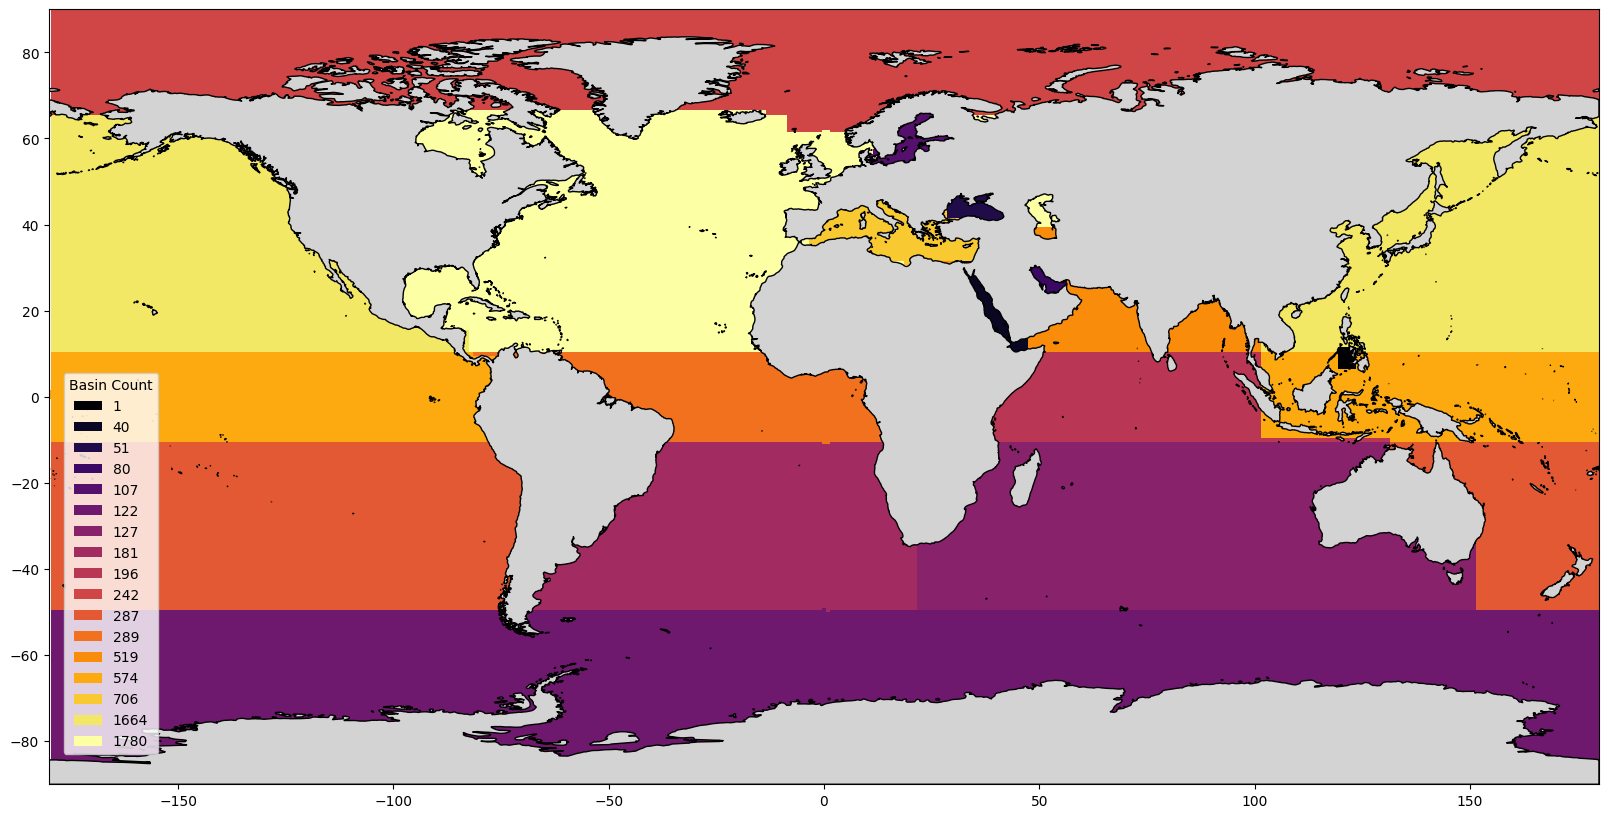

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the continents
continents.plot(ax=ax, color='lightgray', edgecolor='black', zorder=2)

# Create the discrete colormap
cmap = cm.inferno
bounds = np.unique(ocean_df['basin_count'])
norm = colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Plot the oceans
ocean_df.plot(ax=ax, column='basin_count', categorical=False, legend=False,
              cmap=cmap, norm=norm, linewidth=0.8, edgecolor='none', zorder=1)

# Create custom legend
legend_elements = [Patch(facecolor=cmap(norm(basin_count)), edgecolor='none')
                   for basin_count in bounds]
legend_labels = [f'{basin_count}' for basin_count in bounds]
legend = ax.legend(legend_elements, legend_labels, title='Basin Count',
                   loc='lower left', bbox_to_anchor=(0.005, 0.03), fontsize='medium')

# Set the title
ax.set_title("")
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# Show the plot
plt.show()
